In [133]:
import osmnx as ox
import geopandas as gpd
import pyproj
import csv
import matplotlib.pyplot as plt


from shapely.geometry import Point
ox.settings.use_cache=True
ox.settings.log_console=True

In [134]:
pyproj.datadir.set_data_dir('C:\\Users\\isaldiviagonzatti\\anaconda3\\envs\\ox\\Library\\share\\proj')
pyproj.datadir.get_data_dir()

'C:\\Users\\isaldiviagonzatti\\anaconda3\\envs\\ox\\Library\\share\\proj'

### Demonstration
We want to find the nearest edge to the centroids of all polygons representing the PA fields in the north-east region of Costa Rica.

First we demonstrate the process using a single point near Pital

In [135]:
%%time
# lat (y) lon(x) points

xlon = -84.278967
ylat = 10.476319
point = ylat, xlon # center of PA field near Pital

Gex = ox.graph_from_point(point, network_type='all_private', dist=1000)

# project the graph (and point) to a meter projection
Gpex = ox.project_graph(G)

point_geom_proj, crs = ox.projection.project_geometry(Point(reversed(point)), to_crs=Gp.graph['crs'])
x, y = point_geom_proj.x, point_geom_proj.y


CPU times: total: 5.88 s
Wall time: 5.97 s


In [136]:
%%time
# find nearest edge as (u, v, key) and distance to it
test, dist = ox.nearest_nodes(Gpex, Y=y, X=x, return_dist=True)

CPU times: total: 297 ms
Wall time: 362 ms


In [137]:
#convert u,v,key to list
unique_edges = [test]

We also get the distance from the centroid to the edge (street) in meters. This will be used to penalize for transportation within the field

In [138]:
print(round(dist,2), 'meters')

274.95 meters


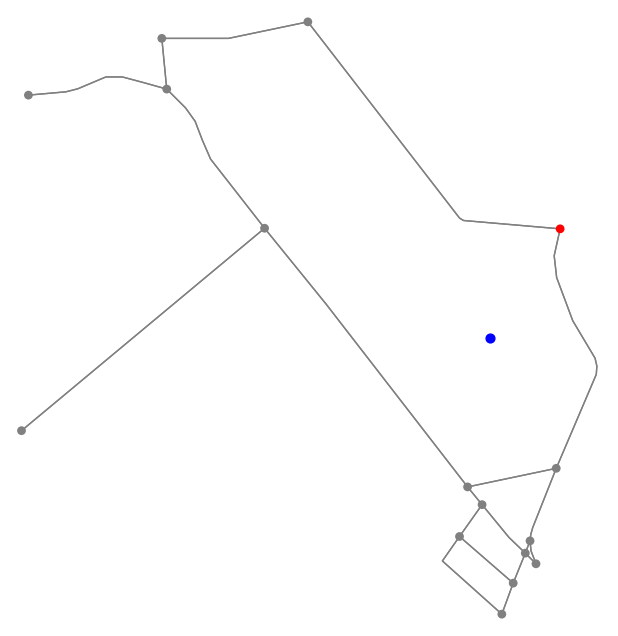

In [142]:
# In yellow is the centoid, in red we see the nearest steet to the centroid
ec = ['red' if e in unique_edges else 'grey' for e in Gex.nodes]
#fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, show=False)
fig, ax = ox.plot_graph(Gex, node_color=ec, edge_linewidth=1, edge_color='grey', node_size=40, show=False, bgcolor='white')
ax = ax.scatter(xlon,ylat,c='blue', s=40, zorder=-1)

fig.savefig('fieldNodeEx.svg', bbox_inches='tight')

### Now we perform the same calculations with all pineapple fields centroids 

In [23]:
## path to PA fields and network
pal = r'C:\Users\isaldiviagonzatti\Downloads/gitFiles/MScThesisCode/FLP/output/ northPAL.gpkg'
networkFile = r'C:\Users\isaldiviagonzatti\Downloads\gitFiles/MScThesisCode/FLP/output/strongNetwork.gpkg'

In [60]:
palPoint = gpd.read_file(pal)

In [61]:
#define lon, lat points
xlon=palPoint['geometry'].x
ylat=palPoint['geometry'].y

In [152]:
#load road network
gdf_nodes = gpd.read_file(networkFile, layer='nodes').set_index('osmid')
gdf_edges = gpd.read_file(networkFile, layer='edges').set_index(['u', 'v', 'key'])
assert gdf_nodes.index.is_unique and gdf_edges.index.is_unique

In [153]:
# convert the node/edge GeoDataFrames to a MultiDiGraph
graph_attrs = {'crs': 'epsg:4326', 'simplified': True}
G = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs)

In [154]:
%%time
G_proj = ox.project_graph(G)

CPU times: total: 6.22 s
Wall time: 6.64 s


In [155]:
# project graph and points to same CRS
geom = gpd.points_from_xy(xlon, ylat)
gdf = gpd.GeoDataFrame(palPoint, crs='epsg:4326').to_crs(G_proj.graph['crs'])

TypeError: 'data' should be array of geometry objects. Use from_shapely, from_wkb, from_wkt functions to construct a GeometryArray.

In [ ]:
%%time
# calculate nearest edge to each point
nePAL = ox.nearest_nodes(G_proj, X=gdf['geometry'].x, Y=gdf['geometry'].y,  return_dist=True)
#nePAL = ox.nearest_edges(G_proj, X=gdf['geometry'].x, Y=gdf['geometry'].y, interpolate=10, return_dist=True)

CPU times: total: 969 ms
Wall time: 1.01 s


In [ ]:
edgesPAL = nePAL[0]
distPAL = nePAL[1]

Let's see how far is the farest centroid from its corresponding street:

In [ ]:
print(max(distPAL), 'meters')

4215.325786369086 meters


In [ ]:
len(unique_edges)

1166

In [ ]:
#convert u,v,key to list
unique_edges = set(edgesPAL)

In [ ]:
Gset = G.subgraph(unique_edges)

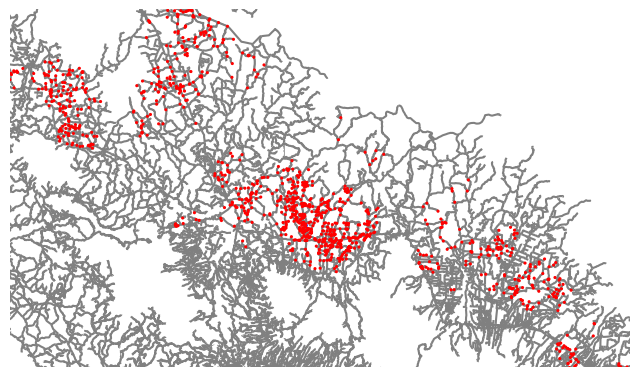

In [ ]:
ec = ['r' if e in unique_edges else 'grey' for e in Gset.nodes]
fig, ax = ox.plot_graph(Gset, node_color=ec, bgcolor='white', edge_color='grey', edge_linewidth=1, node_size=5, show=False, close= False, bbox=(11.04681261,10.09956058,-83.40407159,-85.07389766))
gdf_edges.plot(ax=ax, facecolor='white',  color="grey", zorder=-2)
#fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, show=False, bbox=(11.04681261,10.09956058,-83.40407159,-85.07389766))
ax = ax.scatter(xlon, ylat, c='blue', s=5, zorder=-1)

fig.savefig('allNodesNet.pdf', bbox_inches='tight')

Let's look at the area from the demonstration

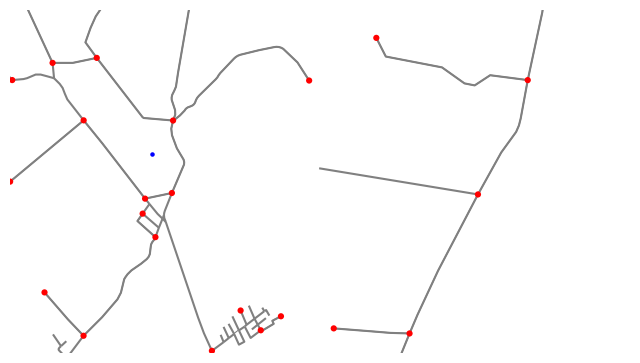

In [ ]:
ec = ['r' if e in unique_edges else 'grey' for e in Gset.nodes]
fig, ax = ox.plot_graph(Gset, node_color=ec, edge_linewidth=1, edge_color='grey', bgcolor='white', node_size=20, show=False, bbox=(10.4854,10.4637,-84.2482,-84.2881))
#fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, show=False, bbox=(10.4854,10.4637,-84.2482,-84.2881))
gdf_edges.plot(ax=ax, facecolor='white',  color="grey", zorder=-2)
ax = ax.scatter(xlon, ylat, c='blue', s=5, zorder=1)

fig.savefig('allZoomNode.pdf', bbox_inches='tight')

#### We save the tuple with osmid and distances to a csv

In [ ]:
with open(r'C:\Users\isaldiviagonzatti\Downloads\gitFiles/MScThesisCode/FLP/output/nearestNodePAL.csv', 'w') as f:
    writer = csv.writer(f , lineterminator='\n')
    for tup in nePAL:
        writer.writerow(tup)